In [227]:
import obspy
import pandas as pd
import numpy as np
import glob,os
import pickle
import matplotlib.pyplot as plt
from obspy.geodetics.base import gps2dist_azimuth

import warnings
warnings.filterwarnings('ignore')

In [12]:
result_SKKS = '/Volumes/home/Research/STEP/02_Station_result_csv/2010-2020_SKKS_classify'
result_SKS = '/Volumes/home/Research/STEP/02_Station_result_csv/2010-2020_SKS_classify'
PKLpath = '/Volumes/home/Research/STEP/01_Split'
Resultcsv='/Volumes/home/Research/STEP/05_Station_result_statistics/Station_SK(K)S_2010-2020average_v4.csv'

In [26]:
dR = pd.read_csv(Resultcsv)

In [107]:
NNR = 65 #dr_['SCphi'].values[0]
error = 20

In [209]:
def plot_vertical(vline=NNR):
    plt.annotate('NNR', xy=(NNR,85), xytext=(NNR-11, 100),
        xycoords='data',clip_on=False,annotation_clip=False,
        arrowprops=dict(arrowstyle="->"))
    plt.annotate('NNR+90', xy=(NNR+90,85), xytext=(NNR+90-20, 100),
        xycoords='data',clip_on=False,annotation_clip=False,
        arrowprops=dict(arrowstyle="->"))
    plt.fill_betweenx(y=[-90,90], x1=vline-error, x2=vline+error,alpha=0.4,color='lightblue')
    plt.fill_betweenx(y=[-90,90], x1=vline+180-error, x2=vline+180+error,alpha=0.4,color='lightblue')
    plt.fill_betweenx(y=[-90,90], x1=vline+90-error, x2=vline+90+error,alpha=0.3,color='grey')
    plt.fill_betweenx(y=[-90,90], x1=vline+270-error, x2=vline+270+error,alpha=0.3,color='grey')


   Station  RCphi  RCdphi  RCdt  RCddt  SCphi  SCdphi  SCdt  SCddt  \
23  IU.GNI   52.0     9.0  0.68   0.19   54.0     8.0  0.76   0.18   

    SKSnonNull  SKSNull  SKKSnonNull  SKKSNull  nonNull  Null  
23          17       84            6        21       23   105  


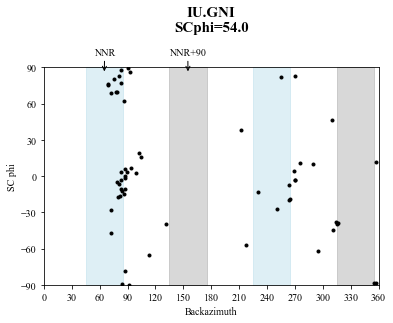

In [272]:
plt.rc('font',family='Times New Roman')

for STApath in glob.glob(f'{PKLpath}/*GNI*.pkl'):
    plt.figure(figsize=(6,4))
    BAZlist = []
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    NET = values['network']; STA = values['station']
    stlat = values['latitude']; stlon = values['longitude']
    dr_   = dR[dR.Station==f'{NET}.{STA}']
    print(dr_)
    dSKKS = pd.read_csv(glob.glob(f'{result_SKKS}/{NET}.{STA}*')[0])
    dSKS  = pd.read_csv(glob.glob(f'{result_SKS}/{NET}.{STA}*')[0])
    
    dSKKS_ = dSKKS[dSKKS.SNRQ>=5][dSKKS.Null==True][dSKKS.Quality=='Good']
    dSKS_  = dSKS[dSKS.SNRQ>=5][dSKS.Null==True][dSKS.Quality=='Good']
    
    df = pd.concat([dSKKS_,dSKS_])
    for i in range(len(df)):
        evlat = df['Ev_lat'].values[i]
        evlon = df['Ev_lon'].values[i]
        SCphi = df['SCPhi'].values[i]
        SCdt  = df['SCdt'].values[i]
        
        dist,az,baz = gps2dist_azimuth(evlat,evlon,stlat,stlon)
        BAZlist.append(baz)

    plt.plot(BAZlist,df['SCPhi'],'o',color='k',markersize=3)
    plot_vertical(vline=NNR)
    plt.title(f'{NET}.{STA}\nSCphi={dr_["SCphi"].values[0]}\n\n',fontsize=15,fontweight='bold')
    plt.xlabel('Backazimuth', fontsize=10)
    plt.xticks(range(0,360+1,30))
    plt.yticks(range(-90,90+1,30))
    plt.xlim(0,360)
    plt.ylim(-90,90)
    plt.ylabel('SC phi', fontsize=10)
    plt.show()
    plt.close()



In [212]:
import pygmt 

In [213]:
regvals = [40, 47, 39.5, 44.5]

In [266]:
pygmt.config(PS_CHAR_ENCODING="ISOLatin1")
figmap = pygmt.Figure()
figmap.basemap(region=regvals, projection="M15c", frame = ['x1f0.5', 'y1f0.5', 'nSeW'])
figmap.grdimage('@earth_relief_30s',region =regvals, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)
figmap.coast(resolution = 'h', shorelines ='0.5/thinnest,black', water='white', borders = '1/0.3p')


coast [WARNING]: Length <unit> t not supported - revert to default unit [point]
coast [WARNING]: 0.5/thinnes not a valid number and may not be decoded properly.


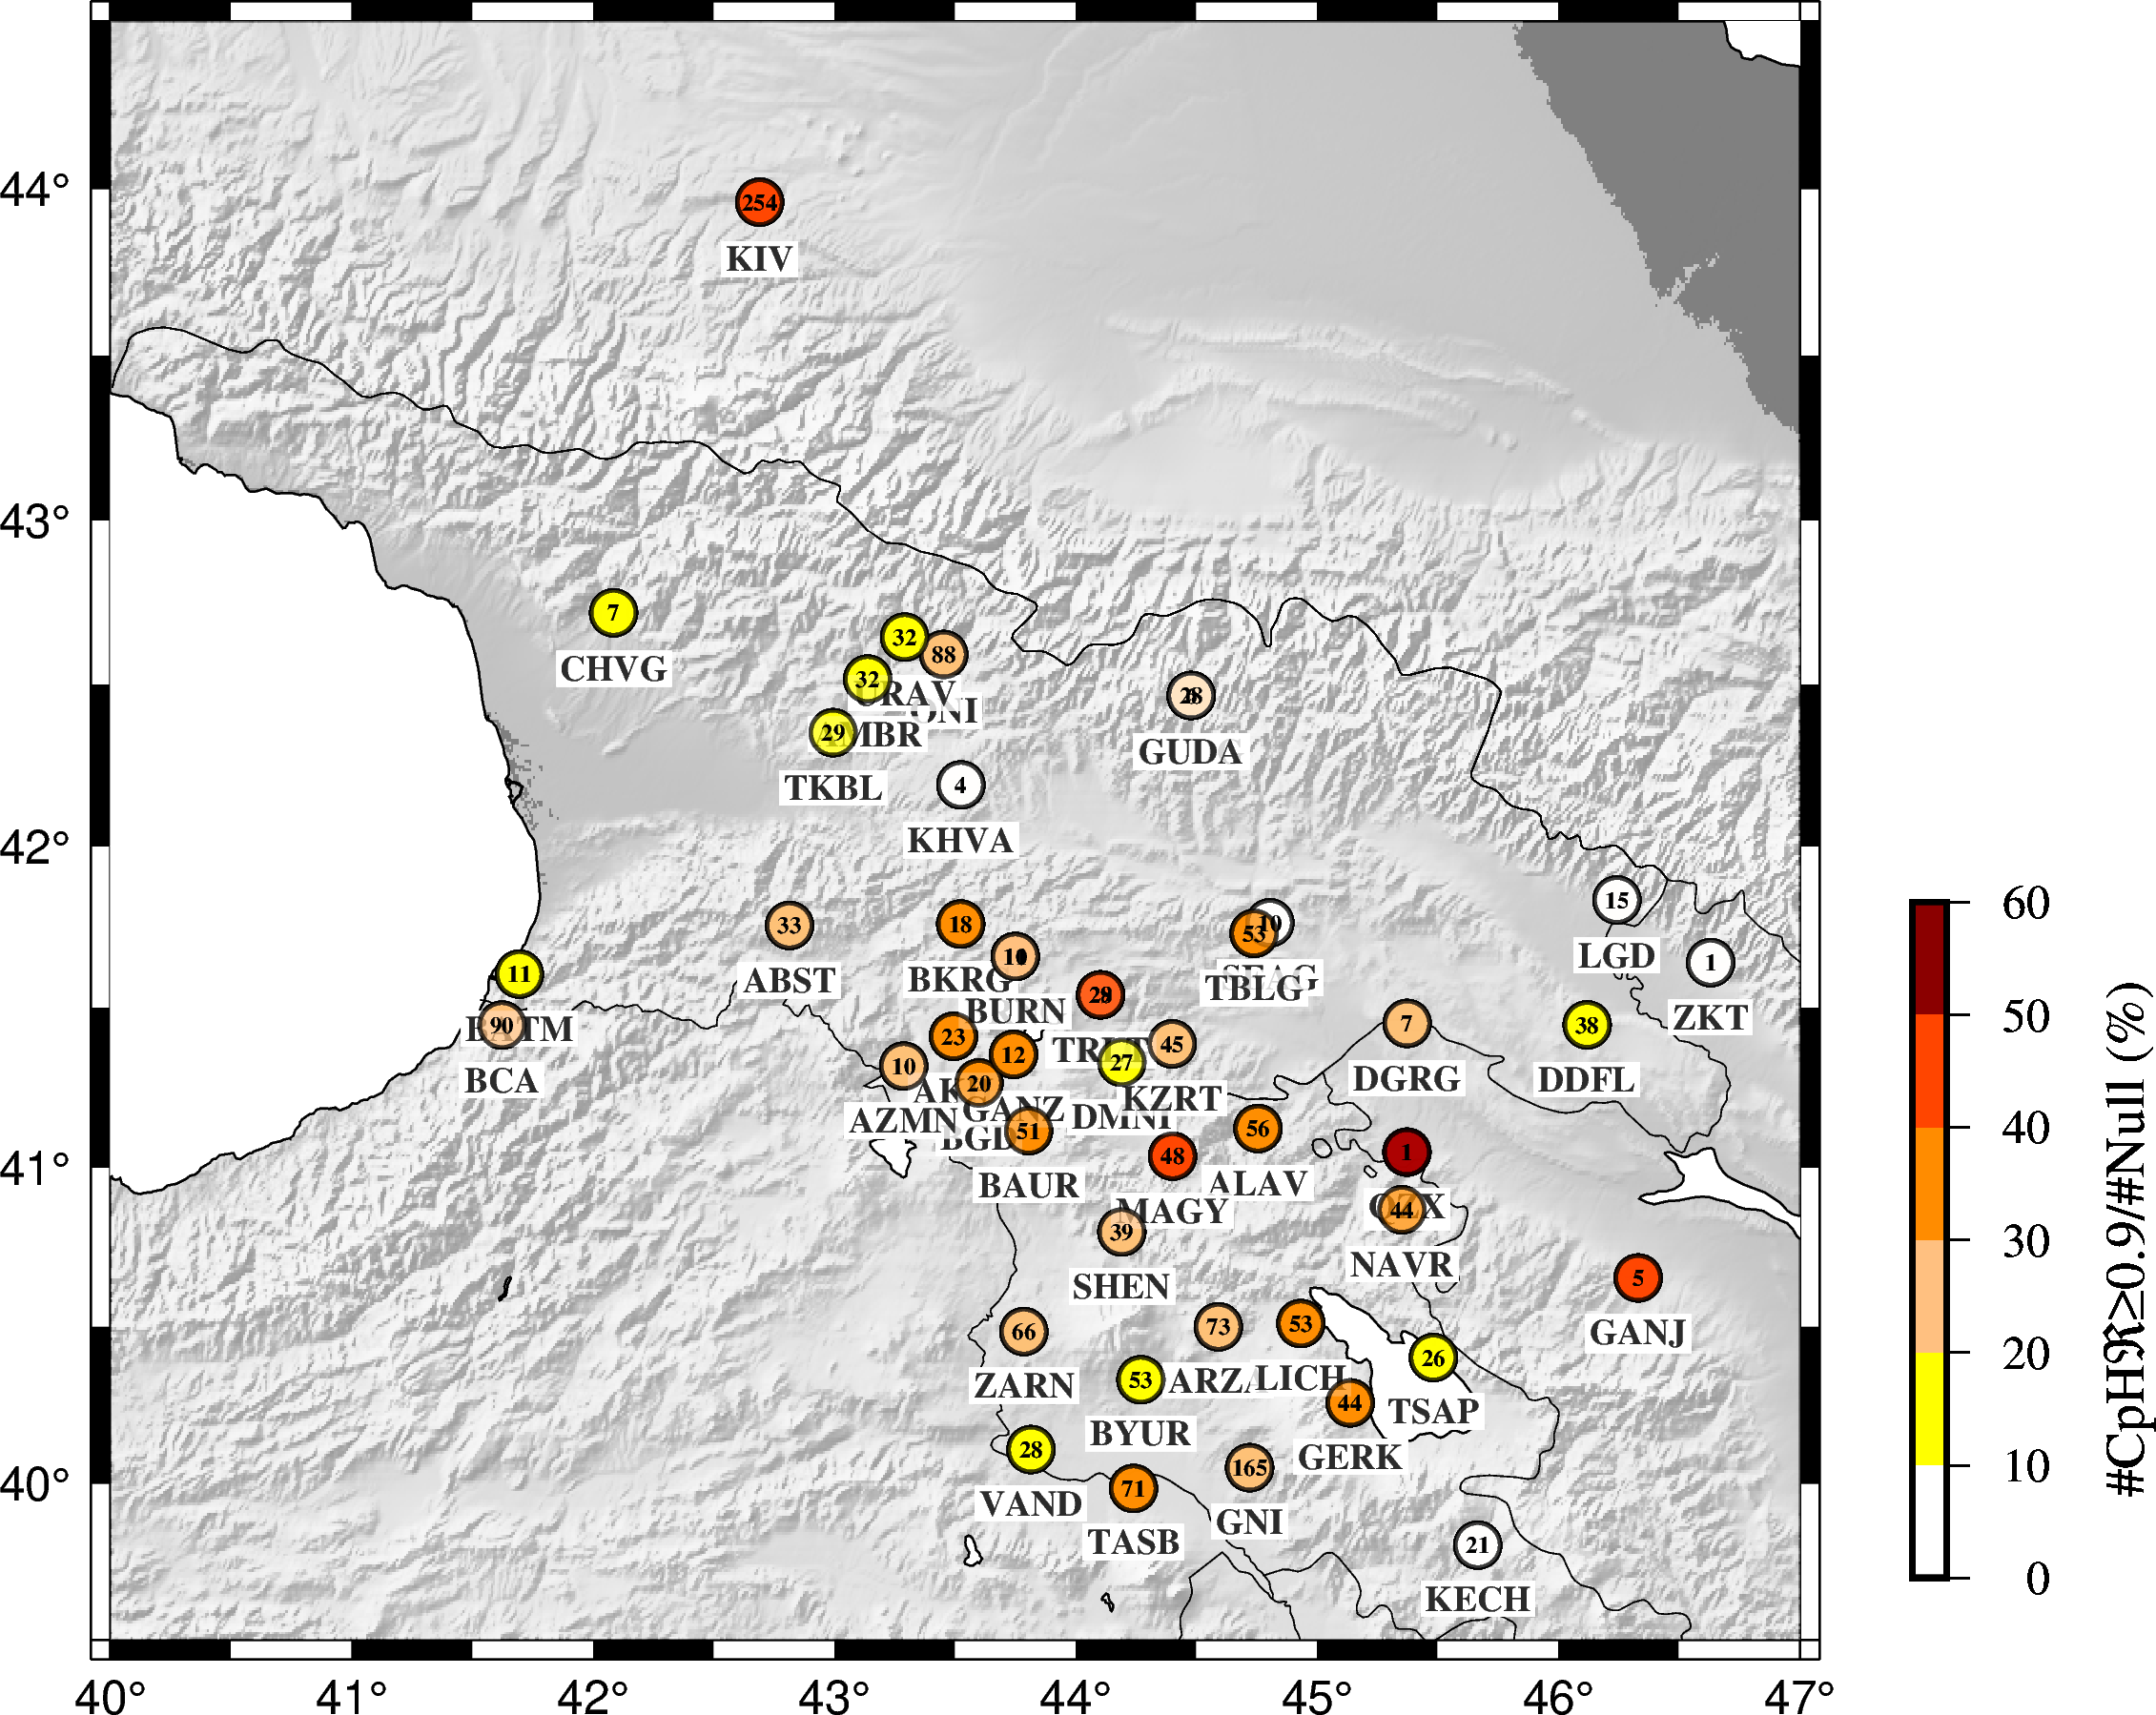

In [274]:
LONlist=[]; LATlist=[]; CpHlist=[]; textlist=[]
for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    NET = values['network']; STA = values['station']
    stlat = values['latitude']; stlon = values['longitude']

    dr_   = dR[dR.Station==f'{NET}.{STA}']
    dSKKS = pd.read_csv(glob.glob(f'{result_SKKS}/{NET}.{STA}*')[0])
    dSKS  = pd.read_csv(glob.glob(f'{result_SKS}/{NET}.{STA}*')[0])
    
    dSKKS_ = dSKKS[dSKKS.SNRQ>=5][dSKKS.Null==True]
    dSKS_  = dSKS[dSKS.SNRQ>=5][dSKS.Null==True]
    df = pd.concat([dSKKS_,dSKS_])
    
    dCpH = df[df['CpH']>=0.9]
    percent = round(len(dCpH)/len(df) * 100, 0)
#     print(f'{NET}.{STA} {percent}')
    LONlist.append(stlon)
    LATlist.append(stlat)
    CpHlist.append(percent)
    textlist.append(len(df))
    figmap.text(x=stlon,y=stlat-0.17,text=STA, font="9p,Times-Bold,black",fill='white',transparency=20)
figmap.plot(x=LONlist,y=LATlist, color = CpHlist,
        cmap = 'cmapCpH_percent.cpt', style="c0.4c", pen="1p,black" ,transparency=30)
figmap.text(x=LONlist,y=LATlist,text=textlist,font="6p,Times-Bold,black")

with pygmt.config(FONT_ANNOT_PRIMARY = '12p,Times-Roman', FONT_LABEL = '14p,Times-Roman',
                  MAP_ANNOT_OFFSET_PRIMARY = '0.3c',
                  MAP_LABEL_OFFSET = '0.5c', 
                  MAP_TICK_LENGTH_PRIMARY = '0.2c',
                  MAP_FRAME_PEN = '1.5p'): 
    figmap.colorbar(cmap = 'cmapCpH_percent.cpt', position = 'x16/0.55+w6c/0.3c+mh', frame = ['a10','x+l"#CpH@~\263@~0.9/#Null (%)"'])
figmap.show() 


In [275]:
figmap.savefig('/Volumes/home/Research/STEP/06_CIA_SWS_result/2010-2020_SK(K)S/00_Plot_Nullnumber_v0.png',dpi=200)
figmap.savefig('/Volumes/home/Research/STEP/06_CIA_SWS_result/2010-2020_SK(K)S/00_Plot_Nullnumber_v0.pdf')